# Mask R-CNN - Train on Objects Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of objects (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Objects* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import re
import time
import matplotlib
import matplotlib.pyplot as plt

parentPath = os.path.abspath("..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)

import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = parentPath

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to COCO trained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

ADE20K_DIR = "/home/orestisz/data/ADE20K_2016_07_26"

Using TensorFlow backend.


In [2]:
# import ADE20K
from ADE20K_dataset import *

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
# # coco dataset
# dataset_coco = coco.CocoDataset()
# dataset_coco.load_coco(COCO_DIR, "minival")
# dataset_coco.prepare()

# Validation dataset
dataset_val = ObjectsDataset()
dataset_val.load_ADE20K(ADE20K_DIR, "validation")
dataset_val.prepare()

## Detection

In [5]:
class InferenceConfig(ObjectsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
# class InferenceConfigCoco(coco.CocoConfig):
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
# inference_config_coco = InferenceConfigCoco()
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)
# model_coco = modellib.MaskRCNN(mode="inference", config=inference_config_coco, model_dir=MODEL_DIR)

/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max: 1024.00000
gt_bbox                  shape: (16, 5)               min:    0.00000  max: 1022.00000
gt_mask                  shape: (1024, 1024, 16)      min:    0.00000  max:    1.00000


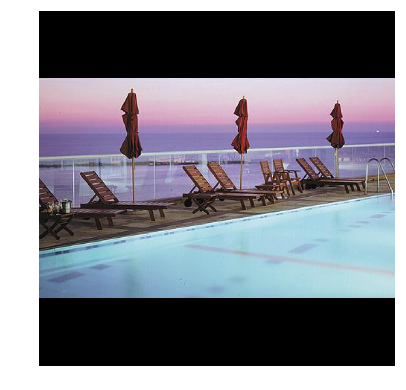

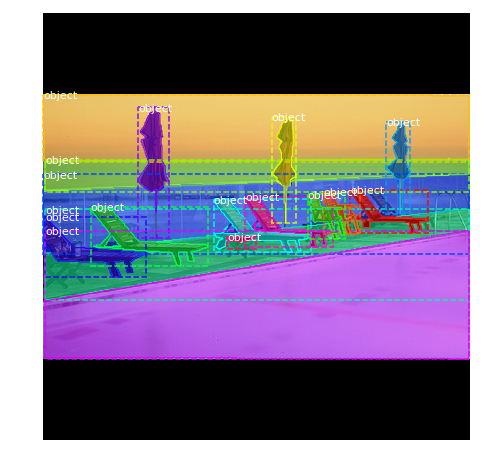

In [10]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
visualize.display_images([original_image], cols=2)

visualize.display_instances(original_image, gt_bbox[:,:4], gt_mask, gt_bbox[:,4], 
                            dataset_val.class_names, figsize=(8, 8))

In [7]:
# coco model
print("Loading weights from Coco Model with all classes")
model_coco.load_weights(COCO_MODEL_PATH, by_name=True)
r = model_coco.detect([original_image])[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_coco.class_names, r['scores'], ax=get_ax())
model_paths = model.find_all()
for model_path in model_paths:
    print("Loading weights from ", model_path[0])
    for checkpoint in model_path[1]:
        print("    " + checkpoint)
        model.load_weights(checkpoint, by_name=True)
        start = time.clock()
        r = model.detect([original_image])[0]
        print(time.clock() - start)
        visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

Loading weights from Coco Model with all classes


NameError: name 'model_coco' is not defined

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox[:,:4], gt_bbox[:,4],
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))